<a href="https://colab.research.google.com/github/hchang18/computer-vision/blob/main/sift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**EE510 Computer Vision**

**Homework 3**

Haeyoon Chang

References (paper, articles, and code blocks): 
- Distinctive Image Features from Scale-Invariant Keypoints, 2004, David G. Lowe
- Prof. James McName's jupyter notebook lecture notes

- https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5

- https://docs.opencv.org/master/d7/d60/classcv_1_1SIFT.html

- https://gist.github.com/lxc-xx/7088609

- https://medium.com/@lerner98/implementing-sift-in-python-36c619df7945



**Implementation of Scale Invariant Feature Transform (SIFT)**

1. **Scale-space extrema detection**: the first stage of computation searches
over all scales and image locations. It is implemented efficiently by
using a difference-of-Gaussian function to identify potential interest
points that are invariant to scale and orientation. 

2. **Keypoint localization**: At each candidate location, a detailed model is to fit to determine location and scale. Keypoints are selected based on measures of their stability

3. **Orientation assignment**: One or more orientations are assigned to each keypoint location based on local image gradient directions. All future operations are performed on image data that has been transformed relative to the assigned orientation, scale, and location for each feature, thereby providing invariance of these transformations. 

4. **Keypoint descriptor**: The local image gradients are measured at the selected scale in the region around each keypoint. These are transformed into a representation that allows for significant levels of local shape distortion and change in illumination. 

**Steps 1 and 2**

In [ ]:
# import libraries 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, eig, det, lstsq
# %matplotlib inline

# mount the google drive to get my image
from google.colab import drive
drive.mount('/content/gdrive')

# function to display two images side by side
# first image (color), second image (grayscale) 
def display_side(img1, img2):
    fig = plt.figure(figsize=(15, 18))
    ax=fig.add_subplot(121)
    ax.imshow(img1, cmap='gray')
    ax=fig.add_subplot(122)
    ax.imshow(img2, cmap='gray')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# function to generate image pyramid and dog pyramid 
def generate_image_pyramid(src_img):
    # parameters
    sigma = 1.6
    num_intervals = 3
    assumed_blur = 0.5

    # Generate base image
    # Doubles the input image in size and apply Gaussian blur 
    image = cv2.resize(src_img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = np.sqrt(max((sigma**2) - ((2*assumed_blur)**2), 0.01)) 
    base_image = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)

    # Compute number of octaves
    # Computes the number of times we can repeatedly 
    # halve an image until it becomes small. 
    # -1 to round down to the neariest integer (floor(x))
    # halving the image num_octaves - 1 times to end up with num_octaves (including base image)
    num_octaves = int(round(np.log(min(base_image.shape)) / np.log(2) - 1))
    

    # Generate Gaussian kernels 
    # Creates a list of the amount of blur for each image 
    # in a particular layer. 
    # - image pyramid has num_octaves layers, 
    # - each layer has num_intervals + 3 images 
    # --- + 1 images to cover num_intervals steps from one blur value to twice that value
    # --- + 2 extra two images at the end to create a DoG image pyramid 

    num_images_per_octave = num_intervals + 3
    k = 2**(1./num_intervals)
    gaussian_kernels = np.zeros(num_images_per_octave)
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k **(image_index - 1)) * sigma
        sigma_total = k*sigma_previous
        gaussian_kernels[image_index] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)

    # Generate scale-space pyramid of Gaussian images
    gaussian_images = []

    for octave_index in range(num_octaves):
        # 1st for-loop for octaves
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)
        for gaussian_kernel in gaussian_kernels[1:]:
            # 2nd for-loop for intervals within each octave
            image = cv2.GaussianBlur(image,(0,0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel) # k-size 0, then they are computed by sigma
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3] # base image for next octave (third-to-last image of previous octave)
        image = cv2.resize(octave_base, 
                        (int(octave_base.shape[1]/2), int(octave_base.shape[0]/2)),
                        interpolation=cv2.INTER_NEAREST)

    gaussian_images = np.array(gaussian_images)

    # Generate Difference of Gaussian images 
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        # 1st for-loop for octaves
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            # 2nd for-loop for intervals within each octave
            dog_images_in_octave.append(np.subtract(second_image, first_image))
        dog_images.append(dog_images_in_octave)

    dog_images = np.array(dog_images)

    print("success - generating image pyramid")

    return gaussian_kernels, gaussian_images, dog_images

In [ ]:
# function to refine the pixel positions of scale-space extrema via 
# quadratic fit around each extrema's neighbors
def localize_keypoint(D, x, y, idx): 
    dx = (D[idx][y,x+1]-D[idx][y,x-1])/2. 
    dy = (D[idx][y+1,x]-D[idx][y-1,x])/2. 
    ds = (D[idx+1][y,x]-D[idx-1][y,x])/2. 
    dxx = D[idx][y,x+1]-2*D[idx][y,x]+D[idx][y,x-1] 
    dxy = ((D[idx][y+1,x+1]-D[idx][y+1,x-1]) - (D[idx][y-1,x+1]-D[idx][y-1,x-1]))/4. 
    dxs = ((D[idx+1][y,x+1]-D[idx+1][y,x-1]) - (D[idx-1][y,x+1]-D[idx-1][y,x-1]))/4. 
    dyy = D[idx][y+1,x]-2*D[idx][y,x]+D[idx][y-1,x] 
    dys = ((D[idx+1][y+1,x]-D[idx+1][y-1,x]) - (D[idx-1][y+1,x]-D[idx-1][y-1,x]))/4. 
    dss = D[idx+1][y,x]-2*D[idx][y,x]+D[idx-1][y,x] 
    J = np.array([dx, dy, ds]) 
    HD = np.array([ [dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]]) 
    offset = -inv(HD).dot(J)

    return offset, J, HD[:2, :2]

In [ ]:
# Find keypoints in one of the DOG octave 
def find_keypoints(selected_dog_octave, gaussian_kernels):
    # keypoints
    keypoints = []
    # image with keypoints marked
    img_marked = []

    for image_index, image in enumerate(selected_dog_octave):
        # for each image in the certain octave (total six)

        # linearize the difference in pixel values (DoG)
        image = image - image.min()
        image = image / image.max()

        # convert the images from Gray to RGB
        # to mark the extrema
        arrayGray = np.array(image*255).astype('uint16')
        layer = cv2.cvtColor(arrayGray, cv2.COLOR_GRAY2RGB)

        nRows = layer.shape[0]
        nColumns = layer.shape[1]
        nChannels = layer.shape[2]

        # traverse each pixel in rows (i) and cols (j) 
        for i in range(1, nRows - 1):
            for j in range(1, nColumns - 1):
                # create 3 x 3 x 3 local block
                local = np.ones((3, 3, 3))* np.nan

                if image_index > 1:
                    img = selected_dog_octave[image_index - 1]
                    local[0,:,:] = img[i-1: i+2, j-1: j+2]

                img = selected_dog_octave[image_index]
                local[1,:,:] = img[i-1: i+2, j-1: j+2]         
                
                if image_index < len(selected_dog_octave) - 1:
                    img = selected_dog_octave[image_index + 1]
                    local[2,:,:] = img[i-1: i+2, j-1: j+2]  

                # if we find the extrema (max and min), 
                # check if image_index is within the image.. 
                if local[1, 1, 1] == np.max(local):
                    if image_index > 0 and image_index < len(selected_dog_octave):
                        offset, J, HD = localize_keypoint(selected_dog_octave, j, i, image_index)
                        D_xhat = selected_dog_octave[image_index][i, j]+0.5*J.dot(offset)

                        # calculate edge response function
                        w, v = eig(HD)
                        r = w[1]/w[0]
                        R = (r + 1)**2 / r                   
                        R_threshold = (10+1)**2/10

                        # eliminate low contrast and edge responses
                        if abs(D_xhat) > 0.03 and R < R_threshold:
                            if image_index == 3:
                                keypoints.append([ j + offset[1], i + offset[0], gaussian_kernels[image_index]])
                            layer[i, j, :] = [255, 0, 0]
                            layer = cv2.circle(layer, (j, i), 2, (255, 0, 0), 2)
                            

                if local[1, 1, 1] == np.min(local):
                    if image_index > 0 and image_index < len(selected_dog_octave):
                        offset, J, HD = localize_keypoint(selected_dog_octave, j, i, image_index)
                        # calculate contrast
                        D_xhat = selected_dog_octave[image_index][i, j]+0.5*J.dot(offset)
                        
                        # calculate edge response function
                        w, v = eig(HD)
                        r = w[1]/w[0]
                        R = (r + 1)**2 / r
                        R_threshold = (10+1)**2/10

                        # eliminate low contrast and edge responses
                        if abs(D_xhat) > 0.03 and R < R_threshold:
                            if image_index == 3:
                                keypoints.append([j + offset[1], i + offset[0], gaussian_kernels[image_index]])
                            layer[i, j, :] = [255, 255, 0]
                            layer = cv2.circle(layer, (j, i), 2, (255, 0, 0), 2) 

        # save image 
        if image_index == 3:
            img_marked = layer

    print("success - find keypoints")
    return keypoints, img_marked


**Orientation Assignment**

- Apply the SIFT feature detection that you used in Homework 2 to identify all of the features within both images. Manually select a feature from the two images that you know is the same. 

In [ ]:
# Process the first image
img = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/house_3.jpg').astype(np.float32) / 255
img_one = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gaussian_kernels, gaussian_images, dog_images = generate_image_pyramid(img_one)
keypoints, house_one_img = find_keypoints(dog_images[1], gaussian_kernels)

# process the second image 
img2 = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/house_4.jpg').astype(np.float32) / 255
img_two = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gaussian_kernels_2, gaussian_images_2, dog_images_2 = generate_image_pyramid(img_two)
keypoints_2, house_two_img = find_keypoints(dog_images_2[1], gaussian_kernels_2)


success - generating image pyramid
success - find keypoints
success - generating image pyramid
success - find keypoints


- Show the pictures side by side with all of the detected features. 

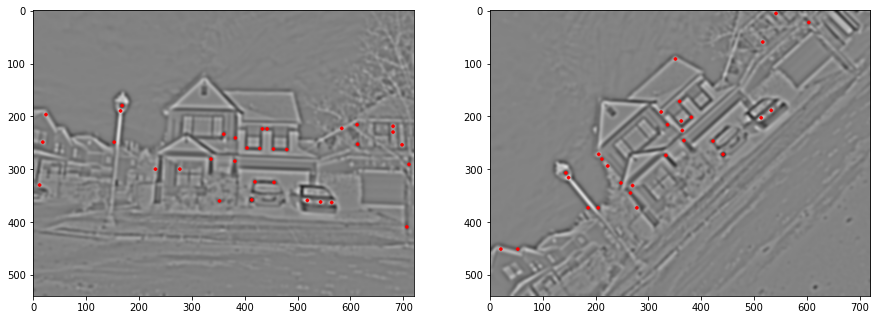

In [ ]:
display_side(house_one_img, house_two_img)

- Create an 8 x 8 array of image gradients similar to that shown in Figure 7 of Lowe and Figure 4.18 in the textbook. Do this for the same feature in both images. 

In [ ]:
print("First image: a total ", len(keypoints), " keypoints")
print("feature selected from the first image")
feature_one = np.array(keypoints[0])
print(np.array(keypoints[0]))
print("\n")
print("Second image: a total ", len(keypoints_2), " keypoints")
print("feature selected from the second image")
print(np.array(keypoints_2[19]))
feature_two = np.array(keypoints_2[19])

First image: a total  33  keypoints
feature selected from the first image
[168.22011604 179.75841853   1.94658784]


Second image: a total  29  keypoints
feature selected from the second image
[143.04288264 306.75154268   1.94658784]


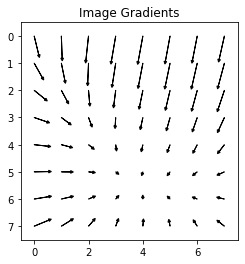

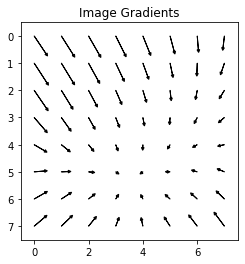

In [ ]:
import pylab as p

# read in the image again 
img_one = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/house_3.jpg').astype(np.float32) / 255
gray_img_one = cv2.cvtColor(img_one, cv2.COLOR_BGR2GRAY)

img_two = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/house_4.jpg').astype(np.float32) / 255
gray_img_two = cv2.cvtColor(img_two, cv2.COLOR_BGR2GRAY)

def get_magnitude_direction(image, feature, cell_size):

    # image blurring using Gaussian and sigma from feature vector
    image = cv2.GaussianBlur(image, (0,0), sigmaX=feature[2], sigmaY=feature[2])

    # locate the upper left corner of the patch  
    loc_x = int(feature[0]) - cell_size // 2
    loc_y = int(feature[1]) - cell_size // 2

    # calculate 8 x 8 gradients 
    G_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    G_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Patch around keypoint
    cell_x = G_x[loc_y: loc_y + cell_size, loc_x: loc_x + cell_size]
    cell_y = G_y[loc_y: loc_y + cell_size, loc_x: loc_x + cell_size]

    # calculate the magnitude and directions
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    directions = np.arctan(cell_y/cell_x)*180 / np.pi

    return cell_x, cell_y, magnitudes, directions

cell_x_one, cell_y_one, magnitude_one, direction_one = get_magnitude_direction(gray_img_one, feature_one, 8)
cell_x_two, cell_y_two, magnitude_two, direction_two = get_magnitude_direction(gray_img_two, feature_two, 8)

# plot this with arrows 
def show_gradient_arrows(cell_x, cell_y):

    nRows = len(cell_x)
    nCols = len(cell_x[0])

    # create blank page
    blank = np.zeros([nRows, nCols, 3],dtype=np.uint8)
    blank.fill(255)
    
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.set_title('Image Gradients')
    ax.imshow(blank, cmap='gray')

    dx = cell_x
    dy = cell_y

    for i in range(nRows):
        for j in range(nCols):
            # p.arrow(x, y, dx, dy, **kwarg)
            p.arrow(j, i, dx[i, j], dy[i, j], fc="k", ec="k",head_width=0.1, head_length=0.1)

# plot it on 8 x 8 image gradients
show_gradient_arrows(cell_x_one, cell_y_one)
show_gradient_arrows(cell_x_two, cell_y_two)

- Repeat for a 16 x 16 array of image gradients 

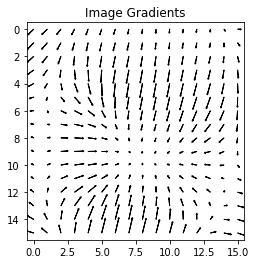

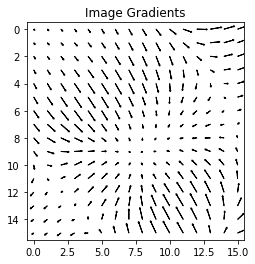

In [ ]:
# get magnitude and directions 
cell_x_one, cell_y_one, magnitude_one, direction_one = get_magnitude_direction(gray_img_one, feature_one, 16)
cell_x_two, cell_y_two, magnitude_two, direction_two = get_magnitude_direction(gray_img_two, feature_two, 16)

# plot it on 16 x 16 image gradients
show_gradient_arrows(cell_x_one, cell_y_one)
show_gradient_arrows(cell_x_two, cell_y_two)

- Create the 2 x 2 descriptor array based on orientation histograms as shown in FIgure 7 of Lowe and Figure 4.18 of the textbook (right side of the figures). Do this for the same feature in both images

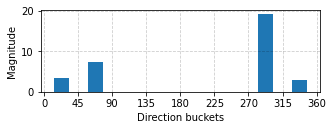

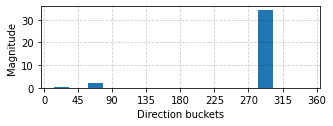

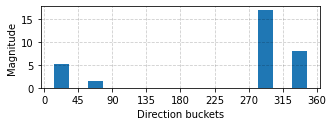

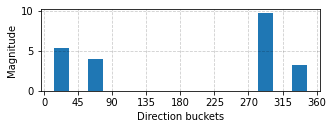

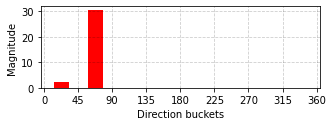

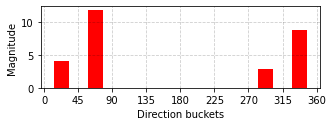

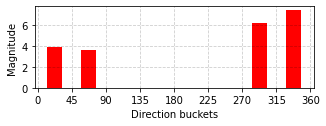

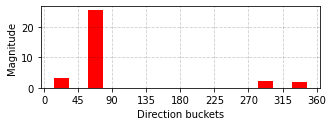

In [ ]:
# calculate HOG block for each cell 
def get_HOG_block_of_cell (magnitudes, directions):

    nRows = directions.shape[0]
    nCols = directions.shape[1]

    # x axis 0 - 360 degrees
    x = [x for x in range(0, 361) if x % 45 == 0]
    xdata = [(x[i]+x[i-1])/2 for i in range(1, len(x))]
    
    # y axis magnitude
    ydata = [ 0 for x in range(8)]

    for i in range(nRows):
        for j in range(nCols):
            remainder = directions[i][j] % 360
            r = int(remainder // 45)
            ydata[r] += magnitudes[i][j]

    return xdata, ydata

# HOG for the first image 
xdata = []
ydata = []
for i in range(0, 16, 8):
    for j in range(0, 16, 8):
        x, y = get_HOG_block_of_cell(magnitude_one[i:i+8, j:j+8], direction_one[i:i+8, j:j+8])
        xdata.append(x)
        ydata.append(y)

for i in range(len(xdata)):
    plt.figure(figsize=(5, 1.5))
    plt.bar(xdata[i], ydata[i], width=20)
    plt.xlabel('Direction buckets')
    plt.ylabel('Magnitude')
    plt.grid(ls="--", color='k', alpha=0.2)
    plt.xticks(np.arange(0, 361, 45))


# HOG for the second image 
xdata_2 = []
ydata_2 = []
for i in range(0, 16, 8):
    for j in range(0, 16, 8):
        x, y = get_HOG_block_of_cell(magnitude_two[i:i+8, j:j+8], direction_two[i:i+8, j:j+8])
        xdata_2.append(x)
        ydata_2.append(y)

for i in range(len(xdata)):
    plt.figure(figsize=(5, 1.5))
    plt.bar(xdata_2[i], ydata_2[i], width=20, color = 'r')
    plt.xlabel('Direction buckets')
    plt.ylabel('Magnitude')
    plt.grid(ls="--", color='k', alpha=0.2)
    plt.xticks(np.arange(0, 361, 45))


**Feature Matching**

Randomly select a feature in one of the images and determine if there is a matching feature in the other image using the method described by Lowe. If there is, indicate this in the image with the number 1 in both images. Repeat this until you have 10 matched features. 

- All the way up to this point, I've tried to find the keypoints in a single layer of one particular octave. 
- I used the following code from here (https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5) loops over this entire section over for 6 layers of each of 8 octaves of the image. 
    - For each keypoint, it generate another histogram of gradient orientation. Based on square neighborhood around each keypoint, we rotate the neighborhood by the keypoint's angle, making it invariant to rotation. 
- OpenCV's template matching was used to match the features. 
    - it computes the SIFT keypoints and descriptors on both images, 
    - it performs approximate nearest neighbors search on the two sets of descriptors to find similar keypoints
    - then, it perform RANSAC on keypoint matches to compute the best fit homography 
- Final result image is in the page 29 
    

In [ ]:
######################
# Source code from https://medium.com/@russmislam/implementing-sift-in-python-a-complete-guide-part-1-306a99b50aa5
# Implementation SIFT in Python: A Complete Guide (Part 1 and 2) by Russ Islam 
######################

from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

####################
# Global variables #
####################

logger = logging.getLogger(__name__)
float_tolerance = 1e-7

#################
# Main function #
#################

def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors

#########################
# Image pyramid related #
#########################

def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(log(min(image_shape)) / log(2) - 1))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images)

###############################
# Scale-space extrema related #
###############################

def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs],
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

#########################
# Keypoint orientations #
#########################

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

##############################
# Duplicate keypoint removal #
##############################

def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

#############################
# Keypoint scale conversion #
#############################

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

#########################
# Descriptor generation #
#########################

def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    logger.debug('Generating descriptors...')
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

finish computeKeypointsAndDescriptors


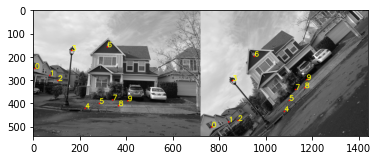

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import logging
logger = logging.getLogger(__name__)

MIN_MATCH_COUNT = 10

img1 = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/house_3.jpg', 0)  
img2 = cv2.imread(F'/content/gdrive/My Drive/Colab Notebooks/ComputerVision/house_4.jpg', 0) 

# Compute SIFT keypoints and descriptors
kp1, des1 = computeKeypointsAndDescriptors(img1)
kp2, des2 = computeKeypointsAndDescriptors(img2)

print("finish computeKeypointsAndDescriptors")

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    # dst = cv2.perspectiveTransform(pts, M)

    # img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    good_selected = [good[0], good[30], good[60], good[90],
                     good[120],good[150], good[180], good[210],
                     good[240], good[270]]
    # Draw SIFT keypoint matches
    for i, m in enumerate(good_selected):
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        cv2.circle(newimg, pt1, 2, (255, 0, 0), 2)
        cv2.putText(newimg, str(i), pt1, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2, cv2.LINE_AA)
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.circle(newimg, pt2, 2, (255, 0, 0), 2)
        cv2.putText(newimg, str(i), pt2, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2, cv2.LINE_AA)
        # cv2.line(newimg, pt1, pt2, (255, 0, 0))

    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))